In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
from keras import ops
import tensorflow as tf
import matplotlib.pyplot as plt
import random
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
mother_dir = "/kaggle/input/medmnist-224"
organ_axial_dir = os.path.join(mother_dir, "organamnist_224")
organ_coronal_dir = os.path.join(mother_dir, "organcmnist_224")
organ_sagittal_dir = os.path.join(mother_dir, "organsmnist_224")
pneumo_dir = os.path.join(mother_dir, "pneumoniamnist_224")

df_organ_axial = pd.read_csv(os.path.join(mother_dir, "organamnist_224.csv"),
                            header = None,
                            names = ["split", 'filename', 'label'])
df_organ_coronal = pd.read_csv(os.path.join(mother_dir, "organcmnist_224.csv"),
                            header = None,
                            names = ["split", 'filename', 'label'])
df_organ_sagittal = pd.read_csv(os.path.join(mother_dir, "organsmnist_224.csv"),
                            header = None,
                            names = ["split", 'filename', 'label'])
df_pneumo = pd.read_csv(os.path.join(mother_dir, "pneumoniamnist_224.csv"),
                            header = None,
                            names = ["split", 'filename', 'label'])

df_organ_axial['filename'] = [os.path.join(organ_axial_dir, f) for f in df_organ_axial['filename']]
df_organ_coronal['filename'] = [os.path.join(organ_coronal_dir, f) for f in df_organ_coronal['filename']]
df_organ_sagittal['filename'] = [os.path.join(organ_sagittal_dir, f) for f in df_organ_sagittal['filename']]
df_pneumo['filename'] = [os.path.join(pneumo_dir, f) for f in df_pneumo['filename']]

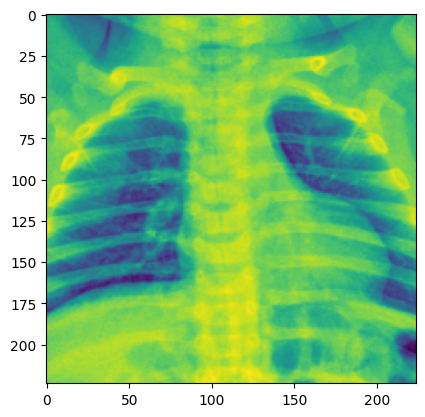

In [3]:
image = np.array(keras.utils.load_img(random.choice(df_pneumo["filename"]), color_mode = 'grayscale')
                )[...,tf.newaxis]
plt.imshow(image)


In [4]:
class RandomVariableCrop(keras.layers.Layer):
    def __init__(self, possible_sizes=[(192, 192), (192, 384), (384, 192), (384, 384)], **kwargs):
        """
        possible_sizes: List of tuples indicating possible (height, width) crop dimensions.
        """
        super(RandomVariableCrop, self).__init__(**kwargs)
        self.possible_sizes = possible_sizes

    def call(self, inputs, training=True):
        # Assume inputs is a single image tensor of shape (H, W, C).
        input_shape = keras.ops.shape(inputs)
        channels = input_shape[2]
        # Randomly select one of the predefined crop sizes.
        num_options = len(self.possible_sizes)
        idx = tf.random.uniform([], minval=0, maxval=num_options, dtype=tf.int32)
        selected_size = self.possible_sizes[idx]
        crop_height, crop_width = selected_size[0], selected_size[1]
        
        # Apply tf.image.random_crop to perform the random crop.
        # Ensure that the input image is large enough for the chosen crop dimensions.
        cropped = keras.layers.RandomCrop(crop_height, crop_width)(inputs)
        #cropped = tf.image.random_crop(inputs, size=[crop_height, crop_width, channels])
        return cropped

    def compute_output_shape(self, input_shape):
        # Since the crop dimensions are chosen randomly, output shape is dynamic.
        return (None, None, input_shape[-1])

aug = keras.Sequential([
        keras.layers.RandomFlip("horizontal_and_vertical"),
        keras.layers.RandomRotation(factor=0.5),
        RandomVariableCrop(possible_sizes=[(224, 112), (112,224), (112,56), (56,112),
                                          (56,224), (224,56),
                                          (112,112), (224,224)])
    ])

# Dataloader from dataframe

tf.Tensor([0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1], shape=(25,), dtype=int64)
(25, 224, 224, 1)


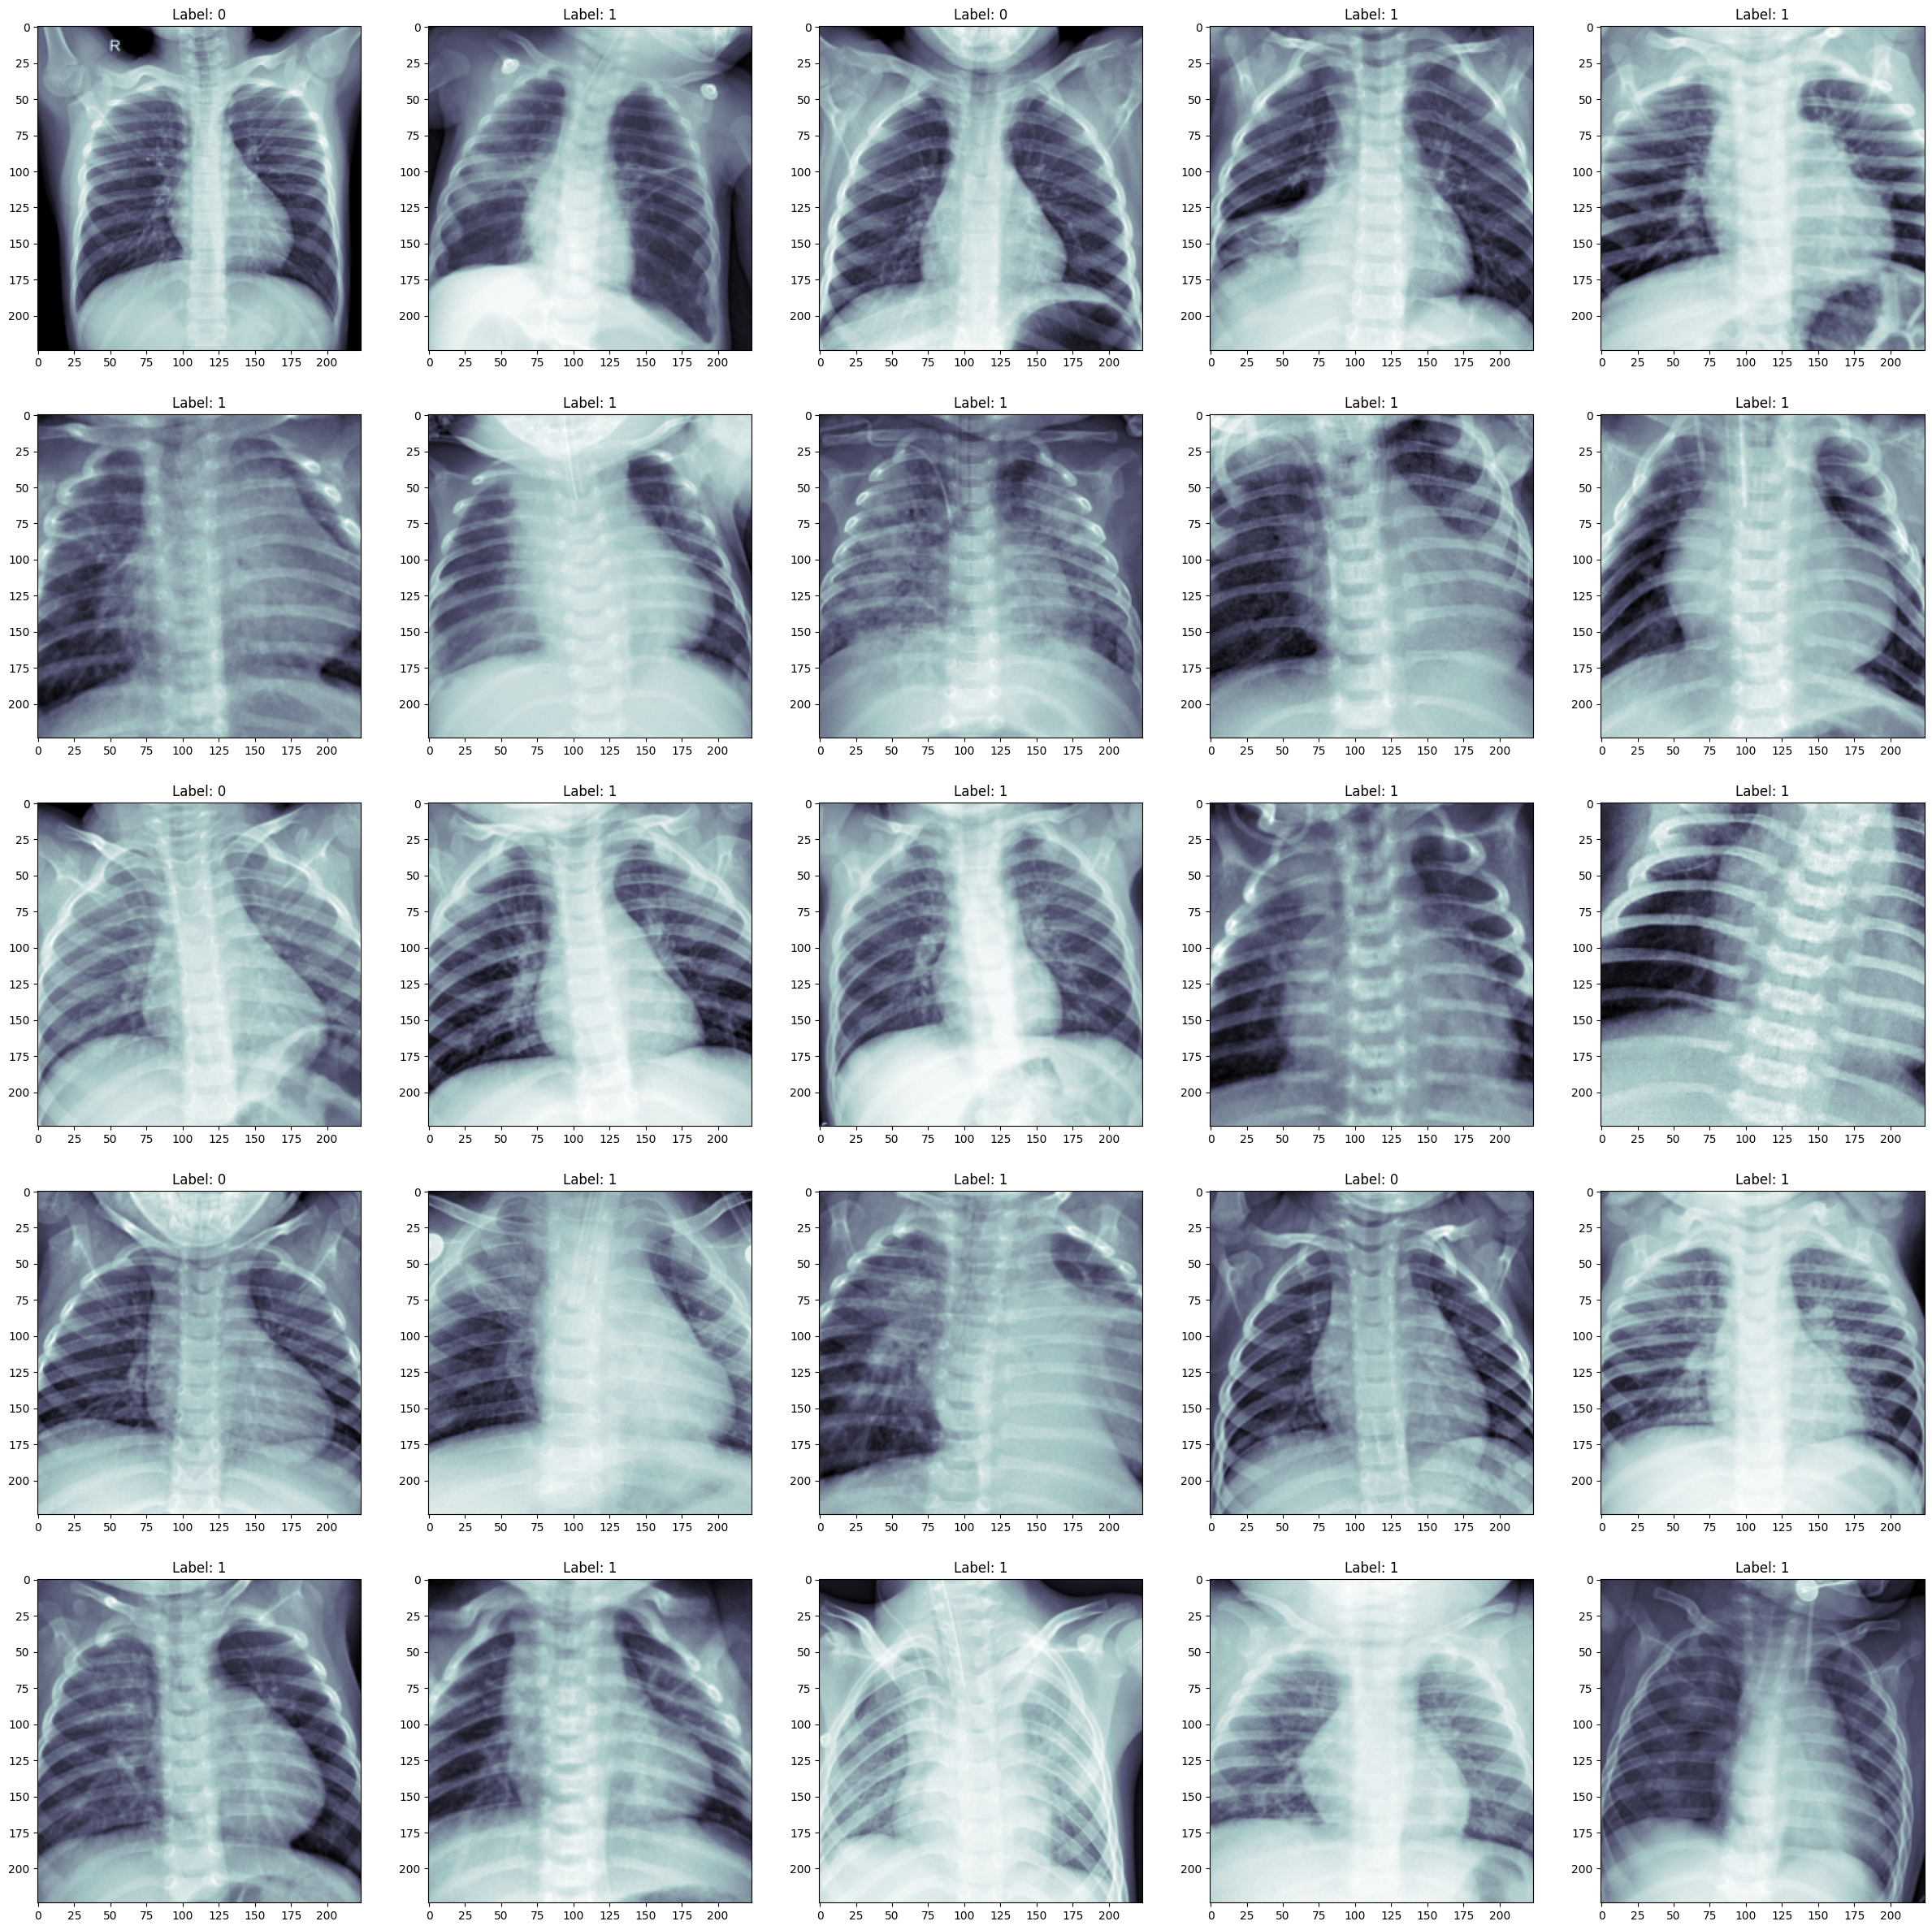

In [5]:
class DatasetGeneratorFromCSV:
    def __init__(
        self,
        dataframe,
        x_col="filename",
        y_col="label",
        image_size=(224, 224),
        batch_size=32,
        shuffle=True,
        split_type=None,
        split_ratio=0.8,
        split_column="split"
    ):
        """데이터셋 생성기 초기화"""
        self.x_col = x_col
        self.y_col = y_col
        self.image_size = image_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.split_ratio = split_ratio
        self.split_column = split_column

        # 데이터 분할 처리 로직
        if split_column in dataframe.columns:
            if split_type is not None:
                split_type = split_type.upper()
                valid_splits = ["TRAIN", "VALIDATION"]
                if split_type not in valid_splits:
                    raise ValueError(f"split_type must be {valid_splits} when split_column exists")
                self.dataframe = dataframe[dataframe[split_column] == split_type]
            else:
                self.dataframe = dataframe
        else:
            if split_type in ["train", "val"]:
                from sklearn.model_selection import train_test_split
                train_df, val_df = train_test_split(
                    dataframe, 
                    train_size=split_ratio, 
                    shuffle=shuffle
                )
                self.dataframe = train_df if split_type == "train" else val_df
            else:
                self.dataframe = dataframe

        self.filenames = self.dataframe[x_col].values
        self.labels = self.dataframe[y_col].values

    def _load_image(self, filename, label):
        """이미지 로드 및 전처리 핵심 함수"""
        image = tf.io.read_file(filename)
        image = tf.image.decode_jpeg(image, channels=1)
        image = tf.image.resize(image, self.image_size, method="bilinear")
        return image, label

    def build_dataset(self):
        """데이터셋 생성 파이프라인"""
        dataset = tf.data.Dataset.from_tensor_slices((self.filenames, self.labels))
        
        # 성능 최적화 설정
        options = tf.data.Options()
        options.threading.private_threadpool_size = tf.data.AUTOTUNE
        options.threading.max_intra_op_parallelism = 1
        dataset = dataset.with_options(options)

        if self.shuffle:
            dataset = dataset.shuffle(buffer_size=3*len(self.filenames))

        dataset = dataset.map(
            self._load_image,
            num_parallel_calls=tf.data.AUTOTUNE
        )
        
        return dataset.batch(self.batch_size, drop_remainder = True).prefetch(tf.data.AUTOTUNE)

gen = DatasetGeneratorFromCSV(df_pneumo, split_type = 'VALIDATION', batch_size = 25)
dataset = gen.build_dataset()

for images, labels in dataset.take(1):
    print(labels)
    print(images.shape)

fig, axes = plt.subplots(5,5, figsize = (30,30))
axes = axes.flatten()
for idx, ax in enumerate(axes):
    ax.imshow(images[idx], cmap = 'bone')
    ax.set_title(f"Label: {labels[idx]}")
plt.show()



In [6]:
def dynamic_masking(images, patch_size, base_ratio=0.4):
    """
    Keras 3.0 호환 동적 마스킹 함수
    
    Args:
        images: 입력 이미지 배치 [batch_size, height, width, channels]
        patch_size: 패치 크기
        base_ratio: 기본 마스킹 비율 (0.0-1.0)
        
    Returns:
        masked_images: 마스킹된 이미지
        mask_flat: 평탄화된 마스크 (1: 마스킹됨, 0: 유지됨)
        patches: 원본 이미지에서 추출한 패치
    """
    
    # 이미지 전처리
    images = ops.cast(images, "float32")
    batch_size = ops.shape(images)[0]
    image_size = ops.shape(images)[1]  # 정사각형 이미지 가정
    P = patch_size
    c = ops.shape(images)[-1]
    
    # 패치 수 계산
    num_patches_h = image_size // P
    num_patches_w = image_size // P
    
    # 1. 지역적 콘트라스트 계산
    if c == 3:  # RGB 이미지인 경우
        # RGB → 그레이스케일 변환 (가중치 적용)
        gray = ops.sum(images * ops.convert_to_tensor([[[[0.299, 0.587, 0.114]]]]), axis=-1, keepdims=True)
    else:  # 이미 그레이스케일이거나 단일 채널
        gray = images
    
    # Sobel 필터 적용 (TF 사용)
    sobel = tf.image.sobel_edges(gray)
    sobel_magnitude = ops.sqrt(ops.sum(ops.square(ops.convert_to_tensor(sobel)), axis=-1))
    
    # 패치 단위로 콘트라스트 맵 다운샘플링
    contrast_patches = ops.image.extract_patches(
        images=sobel_magnitude,
        size=(P, P),
        strides=(P, P),
        dilation_rate=1,
        padding="valid"
    )
    
    # 패치별 평균 콘트라스트 계산
    contrast_map = ops.mean(contrast_patches, axis=-1)
    contrast_map = ops.reshape(contrast_map, [batch_size, num_patches_h, num_patches_w, 1])
    
    # 2. 적응형 마스크 비율 생성
    # Sigmoid 함수: 1/(1+exp(-x))
    adaptive_ratio = 1.0 / (1.0 + ops.exp(-10.0 * (contrast_map - 0.2)))
    mask_ratio = base_ratio * (1.0 + 0.5 * adaptive_ratio)
    
    # 3. 확률적 마스크 생성 (1: 마스킹됨, 0: 유지됨)
    random_values = keras.random.uniform(shape=ops.shape(mask_ratio))
    mask = ops.cast(random_values < mask_ratio, "float32")
    
    # 4. 마스크 업샘플링 및 적용
    mask_up = ops.repeat(mask, P, axis=1)
    mask_up = ops.repeat(mask_up, P, axis=2)
    mask_up = ops.reshape(mask_up, [batch_size, image_size, image_size, 1])
    
    # 마스킹된 이미지 생성 (마스크=1인 위치는 0으로 설정)
    masked_images = images * (1.0 - mask_up)
    
    # 5. 원본 이미지에서 패치 추출
    patches = ops.image.extract_patches(
        images=images,
        size=(P, P),
        strides=(P, P),
        dilation_rate=1,
        padding="valid"
    )
    patches = ops.reshape(patches, [batch_size, num_patches_h * num_patches_w, P*P*c])
    
    # 6. 마스크 평탄화 (loss 계산용)
    mask_flat = ops.reshape(mask, [batch_size, -1])
    
    return masked_images, mask_flat, patches

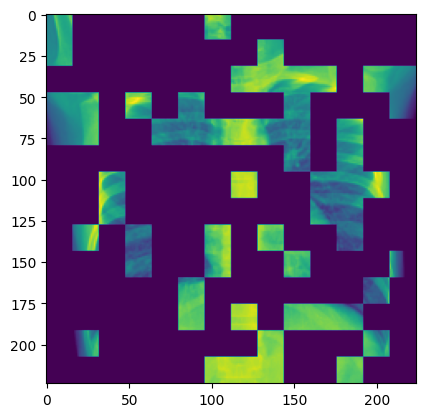

In [7]:
masked_images, mask_indices, patches = dynamic_masking(images, 16, 0.5)
plt.imshow(masked_images[0])